<a href="https://colab.research.google.com/github/ThePituLegend/RISCV-MISE/blob/main/UP_UC_ROM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EJEMPLO: UC CON SECUENCIADOR, BASADA EN ROM

El cálculo a resolver ahora sera el de la raiz cuadrada por defecto de un número natural *x*. Dado un número natural *x*, su raíz cuadrada por defecto puede calcularse mediante el siguiente algoritmo:
```
r <= 0; s <= 1;
while s ≤ x loop
  r <= r + 1;
  s <= s + 2*r + 1;
endloop;
root <= r;
```

##0. Preparativos para simular

Para simular este circuito, emplearemos unos scripts de Python que podéis ejecutar desde esta página.

In [142]:
#@title Ajustes del *Notebook*

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [143]:
#@title Cargar la librería *nbwavedrom*

!pip install nbwavedrom
from nbwavedrom import draw

In [144]:
#@title Cargar la librería *Py4Hw*

!git clone https://github.com/ThePituLegend/py4hw
%cd /content/py4hw
from py4hw import *
%cd /content/

fatal: destination path 'py4hw' already exists and is not an empty directory.
/content/py4hw
/content


In [145]:
#@title Creamos algunos módulos HW necesarios para el ejercicio

class RegSR(Logic):
    """
    This is a D flip flop + Set/Reset feature
    """

    def __init__(self, parent, name:str, d:Wire, e:Wire, q:Wire, s:Wire, r:Wire, sVal:int = 0):
        super().__init__(parent, name)
        self.d = self.addIn("d", d)
        self.e = self.addIn("e", e)
        self.q = self.addOut("q", q)
        self.s = self.addIn("s", s)
        self.r = self.addIn("r", r)
        self.value = 0
        
        if (sVal > 0 and d.getWidth() < int(log2(sVal))+1):
            raise Exception('Invalid set value')

        sValWire = Wire(self, "setValue", 1)
        zero = Wire(self, "zero", 1)
        muxToMux = Wire(self, "muxToMux", self.d.getWidth())
        muxToReg = Wire(self, "muxToReg", self.d.getWidth())
        orWire = Wire(self, "orWire", 1)
        eWire = Wire(self, "enable", 1)

        Constant(self, "setValue", sVal, sValWire)
        Constant(self, "0", 0, zero)
    
        self.muxS = Mux2(self, "muxS", s, d, sValWire, muxToMux)
        self.muxR = Mux2(self, "muxr", r, muxToMux, zero, muxToReg)

        Or(self, "or0", s, r, orWire)
        Or(self, "or1", orWire, e, eWire)

        self.reg = Reg(self, "reg", muxToReg, eWire, q)


class ROM(Logic):
	def __init__(self, parent: Logic, name: str, address: Wire, data: Wire):
		super().__init__(parent, name)

		self.address = self.addIn("address", address)
		self.data = self.addOut("data", data)

		self.wcount = pow(2, address.getWidth())

		self.values = [0] * self.wcount

	def loadROM(self, filename: str, base: int = 10):
		"""
		Load ROM contents from file.

		If content is smaller than ROM size, completes with 0.
		If content is larger than ROM size, excedent is ignored.
		"""

		try:
			dump = []
			self.values = []
			with open(filename) as f:
				dump = f.readlines()

				for x in dump:
					x = x.strip()

					if not x or x.startswith("#"):
						continue
					
					self.values.append(int(x.replace(" ", ""), base))

			ldump = len(self.values)
			if ldump < self.wcount:
				self.values.extend([0 for i in range(self.wcount - ldump)])
			elif ldump > self.wcount:
				self.values = self.values[:self.wcount]

		except OSError as reason:
			print("Error loading ROM: " + str(reason))

	def write(self, address: int, value: int):
		self.values[address] = value

	def read(self, address: int) -> int:
		return self.values[address]

	def propagate(self):
		self.data.put(self.values[self.address.get()])

## 1. Unidad de Proceso

Suponiendo que el valor de *x* estará guardado en un registro externo de *n* bits, vamos a necesitar, como mínimo:

* Tres registros para almacenar los valores de *r*, *s* y *root*. El registro *r* debe poder inicializarse a 0, y el *s* a 1. Los tamaños mínimos necesarios para poder almacenar estos valores ya se han calculado, pero, para mostrar el proceso de diseño de una manera más didáctica evitando tener que prestar atención a detalles que pueden hacernos perder el hilo de la explicación, y a costa de utilizar registros mayores de los estrictamente necesarios, supondremos que todos los registros tienen *n* = 32 bits.

* Un módulo sumador/incrementador que, en función de una señal de control a la que daremos el nombre de *sum/inc* sumará dos números de n bits o incrementará en 1 el valor que le llega por su entrada A (*sum/inc*=1 suma A+B; *sum/inc*=0 realiza la operación A+1).

* Para implementar en hardware la condición *s ≤ x* del while necesitamos modificar la estructura del algoritmo. Una estructura *while (condición) loop … endloop* equivale a una estructura *if (condición) then loop … endloop*:
```
1: r <= 0; s <= 1;
2: if s x loop
3:   r <= r + 1;
4:   s <= s + 2*r +
5: endloop;
6: root <= r;
```

Para implementar el algoritmo en hardware necesitamos convertir la condición en una señal digital; es decir en un voltaje alto (1 lógico) o bajo (0 lógico). Para ello se necesita un nuevo recurso de cálculo capaz de comparar el valor de dos números y decidir si el primero es menor o igual que el segundo. Dicho módulo, al que llamaremos COMPARADOR, tendrá dos entradas de n bits y una salida de 1 bit que tomará el valor 1 si y sólo si el primero de los operandos es menor o igual que el segundo.

>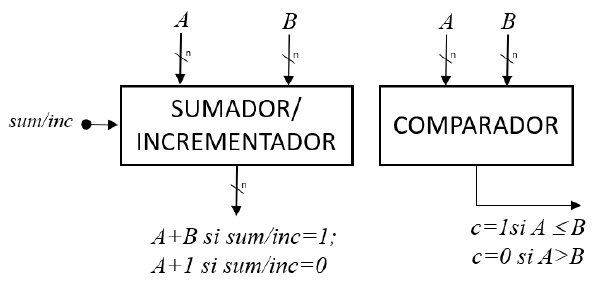

A continuación, tenéis el código que simulará estos dos recursos:

In [146]:
class SumInc(Logic):
    """
    Configurable Incrementer/Adder

    a+b if sel = 1
    a+1 if sel = 0
    """

    def __init__(self, parent, name: str, a: Wire, b: Wire, sel: Wire, r: Wire):
        super().__init__(parent, name)
        self.a = self.addIn("a", a)
        self.b = self.addIn("b", b)
        self.sel = self.addIn("sum/inc", sel)
        self.r = self.addOut("r", r)
        
        self.one = Wire(self, "one", 1)
        self.muxOut = Wire(self, "muxOut", b.getWidth())

        Constant(self, "1", 1, self.one)

        self.mux = Mux2(self, "mux", sel, self.one, b, self.muxOut)
        self.add = Add(self, "add", a, self.muxOut, r)

In [147]:
class LEQ(Logic):
    """
    Less or Equal comparator.

    c = 1 if a <= b
    c = 0 otherwise
    """

    def __init__(self, parent, name: str, a: Wire, b: Wire, c: Wire):
        super().__init__(parent, name)
        self.a = self.addIn("a", a)
        self.b = self.addIn("b", b)
        self.c = self.addOut("c", c)
        
        self.dummy = Wire(self, "", 1)
        self.eq = Wire(self, "equal", 1)
        self.lt = Wire(self, "less", 1)
    
        Comparator(self, "comparator", a, b, self.dummy, self.eq, self.lt)
        Or(self, "or", self.eq, self.lt, c) 

Finalmente, para permitir el encaminamiento de datos, vamos a utilizar una <u>estructura basada en buses</u>, más flexible, aunque frecuentemente más lenta que la estructura basada en multiplexores. Introduciremos dos buses, el *BusA* y el *BusB*, que llevarán los operandos a las entradas de los recursos de cálculo (*BusA*), y que llevarán la salida del módulo SUMADOR/ INCREMENTADOR a los registros (*BusB*):

>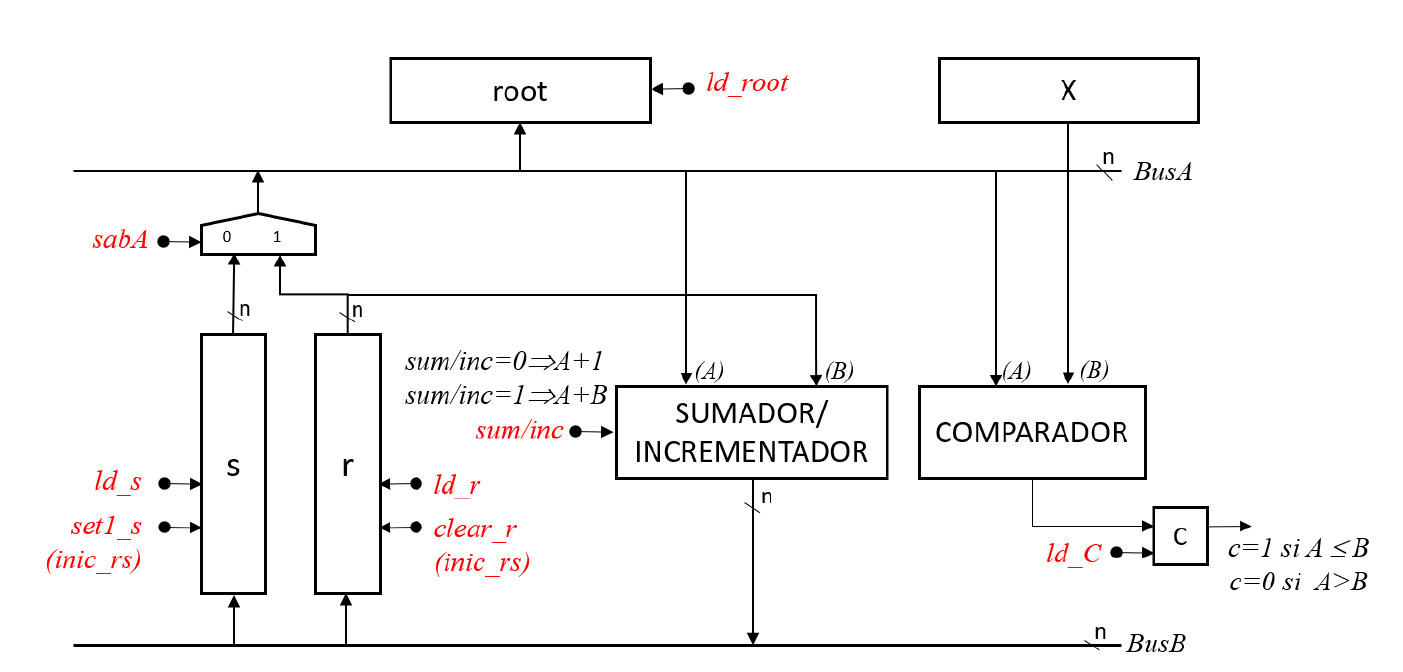

Esta unidad de proceso, donde el encaminamiento de los datos queda definido por dos buses en vez de multiplexores, requiere alguna explicación adicional:

1. *X* es un registro externo que guarda el valor del número *x* cuya raíz se desea calcular, y *root* es el registro donde finalmente se almacenará el resultado final del cálculo.

2. <u>Todos</u> los registros reciben la señal de reloj *CK*. Esta señal no se ha dibujado para no complicar innecesariamente el esquema.

3. Los registros *s* y *r* se han diseñado como registros de carga paralela síncrona, siendo *ld_s* y *ld_r* las señales de carga correspondientes (el registro se carga cuando llega un flanco de subida de *CK* y *ld_s* o *ld_r* está a 1).

4. La señal de control *clear_r* del registro *r* llega a la entrada asíncrona de Reset de los n flip flops del registro, forzándolos a 0 cuando *clear_r*=1. La señal *set1_s* del registro *s* está conectada a la entrada asíncrona de Reset de los n-1 flip flops más significativos, y a la entrada asíncrona de Set del flip flop menos significativo, de modo que cuando *set1_s=1*, los flip flops del registro s toman el valor 000…01.

5. El acceso a los buses puede controlarse de distintas maneras. Aquí se ha optado por utilizar un multiplexor de orden 1 y n bits de forma que, cuando la señal de control *sabA* (**s**eleccionar **a**cceso al **b**usA) toma el valor 0 el registro *s* queda conectado al *BusA*, y cuando *sabA*=1 el registro *r* queda conectado al *BusA*.


A continuación, tenéis el código que simulará la unidad de proceso:

In [148]:
class ProcUnit(Logic):
    """
    Processing Unit for sqrt().
    """
    def __init__(self, parent, name:str, inic_rs:Wire, ld_s:Wire, ld_r:Wire, ld_c:Wire, sabA:Wire, sum_inc:Wire,
        ld_root:Wire, X:Wire, rootOut:Wire, c:Wire):
        super().__init__(parent, name)

        # Init
        self.X = self.addIn(X.name, X)
        self.inic_rs = self.addIn(inic_rs.name, inic_rs)
        self.ld_s = self.addIn(ld_s.name, ld_s)
        self.ld_r = self.addIn(ld_r.name, ld_r)
        self.ld_r = self.addIn(ld_c.name, ld_c)
        self.sabA = self.addIn(sabA.name, sabA)
        self.sum_inc = self.addIn(sum_inc.name, sum_inc)
        self.ld_root = self.addIn(ld_root.name, ld_root)

        self.rootOut = self.addOut(rootOut.name, rootOut)
        self.c = self.addOut(c.name, c)
       
        # Wires (The ones we want to draw will remain as attributes)
        self.s2Mux = Wire(self, "s2Mux", 32)
        self.r2Mux = Wire(self, "r2Mux", 32)
        BusA = Wire(self, "BusA", 32)
        BusB = Wire(self, "BusB", 32)
        c2ff = Wire(self, "c2ff", 1)
        zero = Wire(self, "zero", 1)

        # Constants
        Constant(self, "0", 0, zero)

        # Muxes
        self.mux = Mux2(self, "muxA", sabA, self.s2Mux, self.r2Mux, BusA)

        # Registers
        self.root = Reg(self, "Root", BusA, ld_root, rootOut)
        self.cff = Reg(self, "C", c2ff, ld_c, self.c)
        self.s = RegSR(self, "S", BusB, ld_s, self.s2Mux, inic_rs, zero)
        self.r = RegSR(self, "R", BusB, ld_r, self.r2Mux, zero, inic_rs)

        # Logic Gates
        self.sum = SumInc(self, "Sum/Inc", BusA, self.r2Mux, sum_inc, BusB)
        self.comp = LEQ(self, "Comp", BusA, X, c2ff)

## 2. Unidad de Control


***Insertar explicación y dibujos***


A continuación, tenéis el código que simulará el secuenciador:

In [149]:
class Seq(Logic):
	def __init__(self, parent: Logic, name: str, ld: Wire, SnA: Wire, q: Wire):
		super().__init__(parent, name)

		self.load = self.addIn(ld.name, ld)
		self.SnA = self.addIn(SnA.name, SnA)

		self.q = self.addOut(q.name, q)

		self.value = -1

	def clock(self):
		if self.SnA.get() == 0:
			self.value +=1 
		else:
			self.value = self.load.get()
	
		self.q.prepare(self.value)

A continuación, tenéis el código que simulará el control del secuenciador:

In [150]:
class SeqCtrl(Logic):
	def __init__(self, parent: Logic, name: str, k: Wire, t0: Wire, t1: Wire, SnA: Wire, EuO: Wire):
		super().__init__(parent, name)
		self.k = self.addIn("k", k)
		self.t0 = self.addIn("t0", t0)
		self.t1 = self.addIn("t1", t1)

		self.SnA = self.addOut("SnA", SnA)
		self.EuO = self.addOut("EuO", EuO)

		notT1 = self.wire("notT1")
		midSnA = self.wire("midSnA")

		Not(self, "~t1", self.t1, notT1)
		And(self, "and", notT1, self.k, midSnA)
		Or(self, "or", midSnA, self.t0, self.SnA)

		Repeat(self, "EuO=t1", self.t1, self.EuO)

A continuación, tenéis el código que simulará la unidad de control:

In [151]:
class CtrlUnit(Logic):
	"""
	Control Unit for sqrt().
	"""

	def __init__(self, parent, name: str, c: Wire, inicio: Wire,
				 inic_rs: Wire, ld_s: Wire, ld_r: Wire, ld_c: Wire, sabA: Wire, sum_inc: Wire, ld_root: Wire, fin: Wire):
		super().__init__(parent, name)

		# Init
		self.c = self.addIn(c.name, c)
		self.inicio = self.addIn(inicio.name, inicio)

		self.inic_rs = self.addOut(inic_rs.name, inic_rs)
		self.ld_s = self.addOut(ld_s.name, ld_s)
		self.ld_r = self.addOut(ld_r.name, ld_r)
		self.ld_c = self.addOut(ld_c.name, ld_c)
		self.sabA = self.addOut(sabA.name, sabA)
		self.sum_inc = self.addOut(sum_inc.name, sum_inc)
		self.ld_root = self.addOut(ld_root.name, ld_root)
		self.fin = self.addOut(fin.name, fin)

		nInicio = self.wire("nInicio")
		nC = self.wire("nC")
		k = self.wire("k")
		SnA = self.wire("SnA")
		EuO = self.wire("EuO")
		self.addr = self.wire("Address", 4)
		load = self.wire("GOTO Addr", 4)
		self.word = self.wire("ROM Word", 11)

		wBits = self.wires("ROM Bits", 11, 1)

		Bits(self, "ROM Bits", self.word, wBits)

		# Bits renaming, for convenience
		fn, ldr, ldc, si, d0, d1, d2, d3, t0, t1, i = wBits
		Concatenate(self, "GOTO Addr", [d3, d2, d1, d0], load)

		self.rom = ROM(self, "ROM", self.addr, self.word)
		self.rom.loadROM("sqrt.bin", 2)

		Not(self, "~Inicio", self.inicio, nInicio)
		Not(self, "~C", self.c, nC)

		Mux2(self, "condMux", i, nInicio, nC, k)

		self.seqCtrl = SeqCtrl(self, "Seq. Ctrl", k, t0, t1, SnA, EuO)
		self.seq = Seq(self, "Sequentiator", load, SnA, self.addr)

		Repeat(self, "fin", fn, self.fin)
		Repeat(self, "sum/inc", si, self.sum_inc)
		Repeat(self, "sabA", d0, self.sabA)

		And(self, "ld_root_enabled", ldr, EuO, self.ld_root)
		And(self, "ld_c_enabled", ldc, EuO, self.ld_c)
		And(self, "ld_r_enabled", d1, EuO, self.ld_r)
		And(self, "ld_s_enabled", d2, EuO, self.ld_s)
		And(self, "inic_rs_enabled", d3, EuO, self.inic_rs)

## 3. TestBench

In [152]:
sys = HWSystem()

inic_rs = sys.wire("inic_rs")
ld_s = sys.wire("ld_s")
ld_r = sys.wire("ld_r")
ld_c = sys.wire("ld_c")
sabA = sys.wire("sabA")
sum_inc = sys.wire("sum_inc")
ld_root = sys.wire("ld_root")
X = sys.wire("X", 32)
root = sys.wire("root", 32)
c = sys.wire("c")
inicio = sys.wire("inicio")
fin = sys.wire("fin")

Constant(sys, "X", 25, X)
inicio.value = 0

proc = ProcUnit(sys, "UP", inic_rs, ld_s, ld_r, ld_c,
				sabA, sum_inc, ld_root, X, root, c)
ctrl = CtrlUnit(sys, "UC", c, inicio, inic_rs, ld_s,
				ld_r, ld_c, sabA, sum_inc, ld_root, fin)

wave1 = Waveform(sys, "ROM + Resultados", [ctrl.addr, ctrl.word, proc.s2Mux, proc.r2Mux, root])
wave2 = Waveform(sys, "uOrdenes", [inic_rs, ld_s, ld_r, ld_c, sabA, sum_inc, ld_root, c, fin])

#py4hw.debug.printHierarchyWithValues(sys)

sim = sys.getSimulator()

sim.clk(1)
inicio.value = 1
sim.clk(2)

while fin.get() != 1:
  sim.clk(1)

draw(wave1.get_waveform())
draw(wave2.get_waveform())
draw(wave3.get_waveform())